In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from datetime import datetime
import requests
import os

In [2]:
## Data source: https://www.alphavantage.co/documentation/

#function = 'TIME_SERIES_INTRADAY'
function = 'TIME_SERIES_INTRADAY_EXTENDED'
symbol = 'IBM'
data_slice = 'year1month1'
api_key = 'KFJG8PX80JIDVVF8'
interval = '5min'
data_type = 'csv'

query = requests.get(
    f'https://www.alphavantage.co/query?function={function}&'
    f'symbol={symbol}&interval={interval}'
    f'&slice={data_slice}&apikey={api_key}'
    ).content

data = pd.read_csv(io.StringIO(query.decode('utf-8')))
data.head(10)

,time,open,high,low,close,volume
0,2021-01-15 19:50:00,128.3000,128.3000,128.3000,128.3000,120
1,2021-01-15 19:45:00,128.3900,128.3900,128.3900,128.3900,300
2,2021-01-15 19:35:00,128.3900,128.3900,128.3900,128.3900,1631
3,2021-01-15 19:00:00,128.3900,128.3900,128.3900,128.3900,100
4,2021-01-15 18:40:00,128.3900,128.3900,128.3900,128.3900,860
5,2021-01-15 18:00:00,128.2000,128.2000,128.2000,128.2000,100
6,2021-01-15 16:55:00,128.1300,128.1300,128.1300,128.1300,373
7,2021-01-15 16:45:00,128.3000,128.3000,128.3000,128.3000,302
8,2021-01-15 16:30:00,128.3000,128.3000,128.3000,128.3000,100
9,2021-01-15 16:15:00,128.4093,128.4093,128.3900,128.3900,8445


In [78]:
# Save data
if not os.path.exists('./data'):
    os.makedirs('./data')

today = datetime.today().strftime('%Y%m%d')
data.to_csv(f'./data/{symbol}-{interval}-{today}.csv', index=False)

## Step 1 - Data visualization and some basic stats

In [79]:
## Read data
date = '20210120'
interval = '5min'
symbol = 'IBM'
data = pd.read_csv(f'./data/{symbol}-{interval}-{date}.csv')

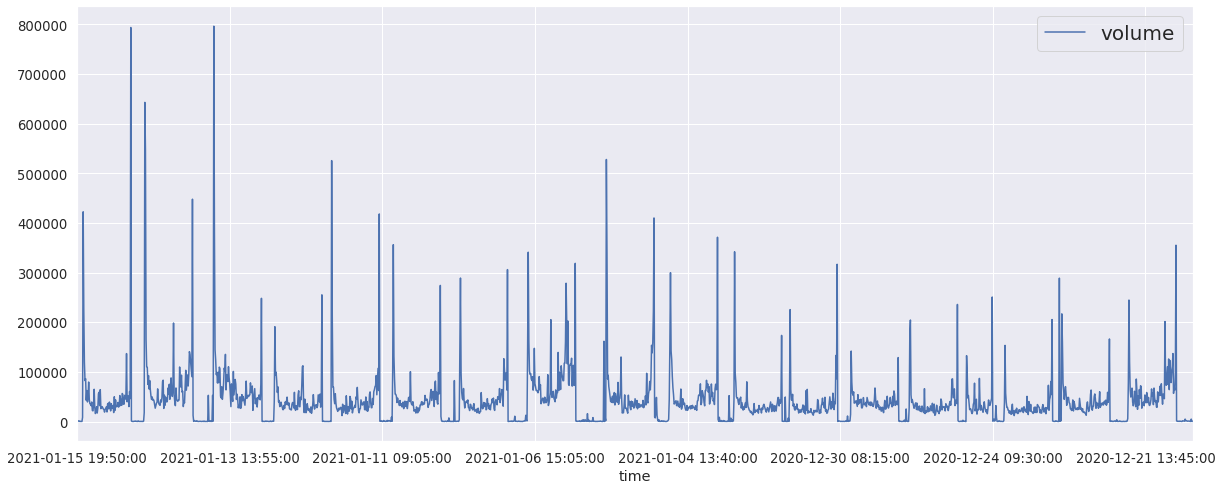

In [84]:
data = data.sort_values('time', ascending=False)
ax = data.plot('time', 'volume', figsize=(20,8))
ax.legend(fontsize=20)

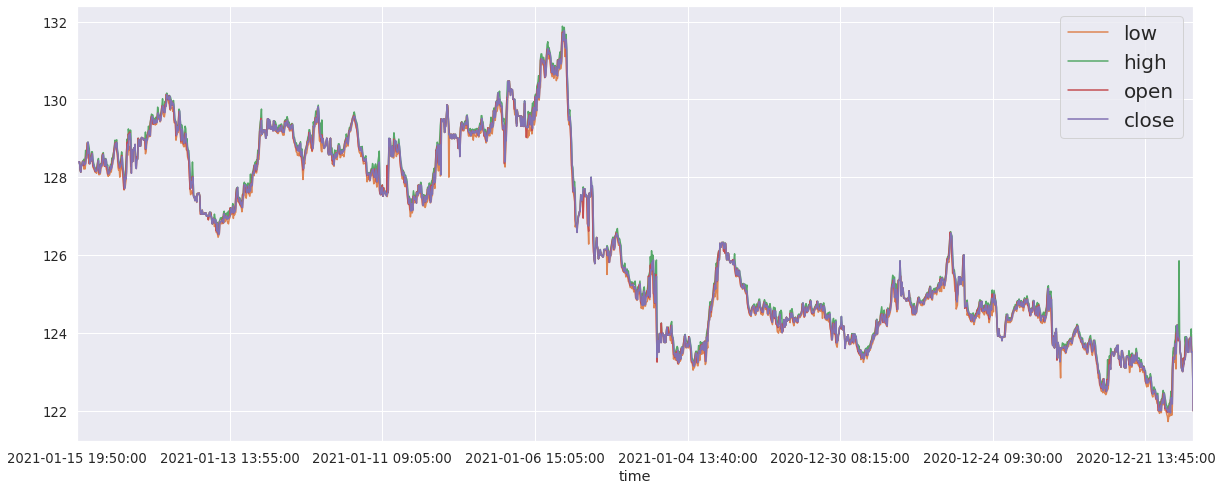

In [85]:
ax = data.plot('time', 'low', color="C1", figsize=(20,8))
data.plot('time', 'high', ax=ax, color="C2")
data.plot('time', 'open', ax=ax, color="C3")
data.plot('time', 'close', ax=ax, color="C4")
ax.legend(fontsize=20)

## Step 2 - Train test split

In [112]:
train_size = int(len(data) * 0.8)
test_size = int(len(data) * 0.1)
validation_size = int(len(data) * 0.1)

train, test = data[0:train_size], data[train_size:train_size+test_size]
validation = data[train_size+test_size:-1]

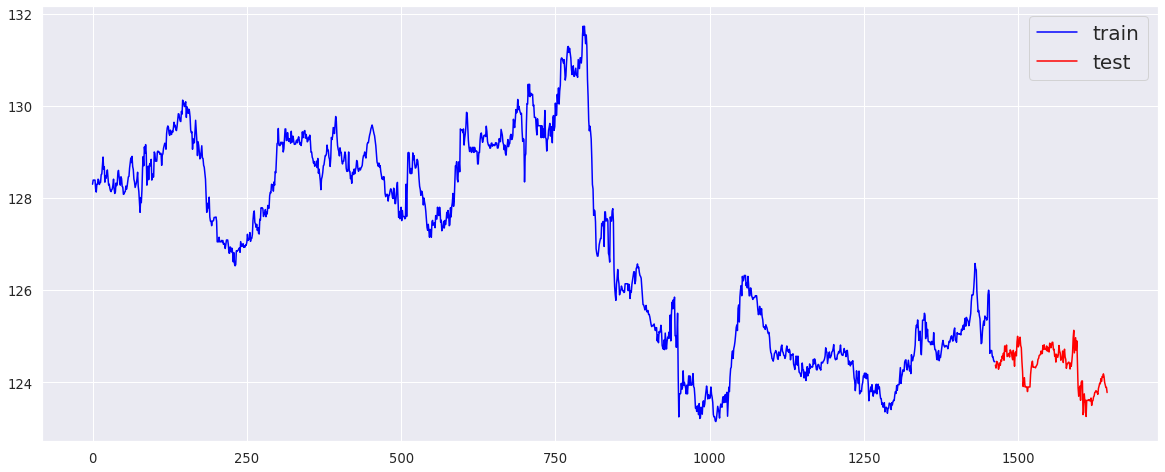

In [109]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))
ax.plot(list(train['open']), color="blue", label='train')
ax.plot([None for i in train['open']] + list(test['open']), color="red", label='test')
ax.legend(fontsize=20)

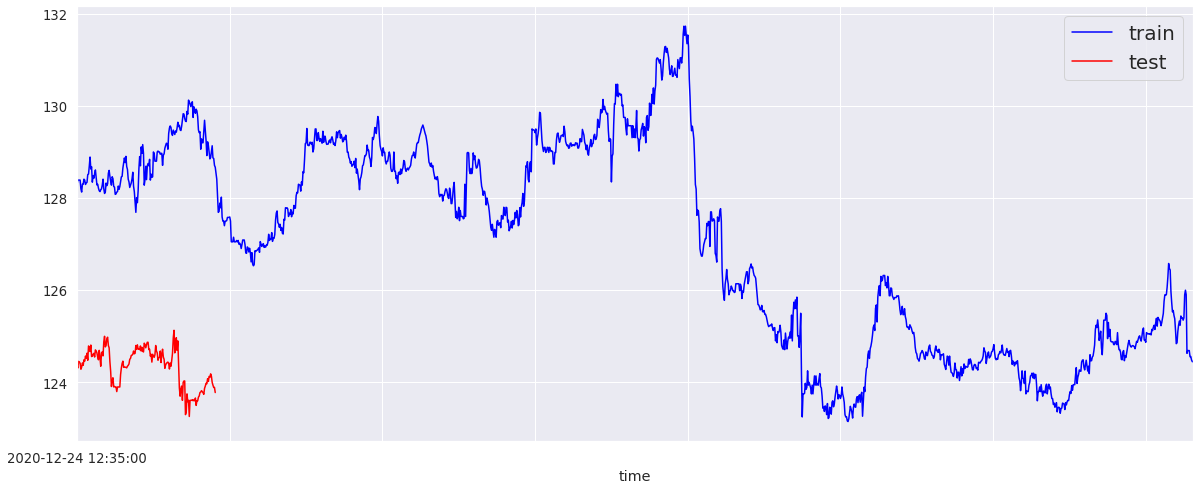

In [96]:
ax = train.plot('time', 'open', color="blue", label='train')
test.plot('time', 'open', ax=ax, color="red", label='test', figsize=(20,8))
ax.legend(fontsize=20)


In [ ]:
test.plot('time', 'open', color="red", label='test')

## Step 3 - ARIMA model

In [125]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [120]:
train.append(test)['open'].to_numpy()

array([128.3   , 128.39  , 128.39  , ..., 123.89  , 123.89  , 123.7794])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1645
Model:                ARIMA(21, 1, 0)   Log Likelihood                 490.910
Date:                Fri, 29 Jan 2021   AIC                           -937.819
Time:                        05:00:56   BIC                           -818.912
Sample:                             0   HQIC                          -893.725
                               - 1645                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0751      0.016     -4.813      0.000      -0.106      -0.045
ar.L2         -0.0175      0.020     -0.894      0.371      -0.056       0.021
ar.L3          0.0251      0.019      1.341      0.1

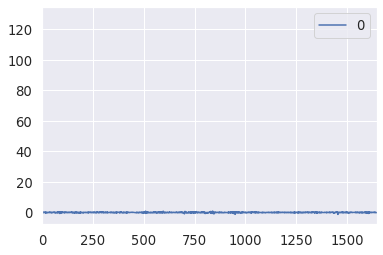

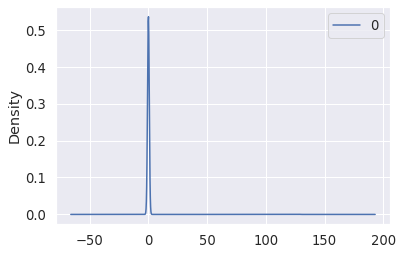

                 0
count  1645.000000
mean      0.075074
std       3.168483
min      -1.284684
25%      -0.088017
50%      -0.001857
75%       0.090229
max     128.300000


In [124]:
# fit model
model = ARIMA(train.append(test)['open'].to_numpy(), order=(21,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [139]:
%%time
predictions = list()
history = [x for x in train['open']]
# walk-forward validation
print('Test size: ', len(test))
for t in range(len(test)):
    model = ARIMA(history, order=(21,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['open'].to_numpy()[t]
    history.append(obs)
    if (t % 5 == 0) | (t == len(test)):
        print('time %d: predicted=%f, expected=%f, err=%f, bias=%f%%' 
              % (t+1, yhat, obs, yhat-obs, 100*(yhat/obs-1)))

Test size:  182
time 1: predicted=124.346910, expected=124.370000, err=-0.023090, bias=-0.018565%
time 6: predicted=124.387923, expected=124.285000, err=0.102923, bias=0.082812%
time 11: predicted=124.453038, expected=124.460000, err=-0.006962, bias=-0.005594%
time 16: predicted=124.489729, expected=124.790000, err=-0.300271, bias=-0.240621%
time 21: predicted=124.591383, expected=124.570000, err=0.021383, bias=0.017166%
time 26: predicted=124.695021, expected=124.680100, err=0.014921, bias=0.011968%
time 31: predicted=124.663193, expected=124.540000, err=0.123193, bias=0.098918%
time 36: predicted=124.605135, expected=124.880000, err=-0.274865, bias=-0.220103%
time 41: predicted=124.924303, expected=124.980000, err=-0.055697, bias=-0.044564%
time 46: predicted=124.265772, expected=123.910000, err=0.355772, bias=0.287121%
time 51: predicted=123.849175, expected=123.900000, err=-0.050825, bias=-0.041021%
time 56: predicted=123.914475, expected=123.900000, err=0.014475, bias=0.011683%
ti

In [ ]:
%%time
predictions = list()
history = [x for x in train['open']]
# walk-forward validation
print('Test size: ', len(test))
for t in range(len(test)):
    model = ARIMA(history, order=(21,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['open'].to_numpy()[t]
    history.append(obs)
    if (t % 5 == 0) | (t == len(test)):
        print('time %d: predicted=%f, expected=%f, err=%f, bias=%f%%' 
              % (t+1, yhat, obs, yhat-obs, 100*(yhat/obs-1)))

Test RMSE: 0.153
Test MSE: 0.107
Test PMSE: 0.001


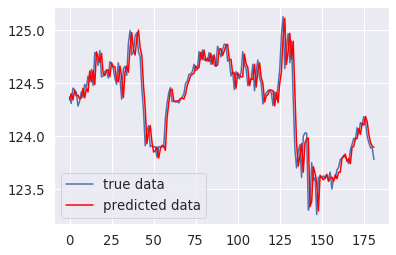

In [153]:
# evaluate forecasts
def cal_mse(x, y):
    assert len(x) == len(y), 'The inputs should have the same size!'
    err, perr = 0, 0
    for i in range(len(x)):
        err += abs(x[i]-y[i])
        perr += abs(x[i]-y[i])/x[i]
    return 1.0 * err / len(x), 1.0 * perr / len(x)

rmse = sqrt(mean_squared_error(test['open'].to_numpy(), predictions))
mse, pmse = cal_mse(test['open'].to_numpy(), predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MSE: %.3f' % mse)
print('Test PMSE: %.3f' % pmse)
# plot forecasts against actual outcomes
plt.plot(test['open'].to_numpy(), label='true data')
plt.plot(predictions, color='red', label='predicted data')
plt.legend()
plt.show()

In [4]:
('https://www.alphavantage.co/'
'query?function=')

'https://www.alphavantage.co/query?function='